# IEMOCAP Dataset

reference: https://github.com/Aditya3107/IEMOCAP_EMOTION_Recognition

## Mount the drive folder

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
#%cd /content/drive/My Drive/MSER/data/IEMOCAP_full_release
%cd /content/drive/My Drive/JPMC_capstone/data/IEMOCAP_full_release
!ls

/content/drive/.shortcut-targets-by-id/1o_8PjrQSV2_XG-IYBPNFwY0h7jALADQJ/data/IEMOCAP_full_release
Documentation  README.txt~  Session2  Session4
README.txt     Session1     Session3  Session5


## Load the label

In [4]:
import re
import os

regex = re.compile(r'\[.+\]\n', re.IGNORECASE)
start_times, end_times, wav_file_names, emotions, vals, acts, doms = [], [], [], [], [], [], []

for session in range(1, 6):
    emo_evaluation_dir = f'Session{session}/dialog/EmoEvaluation/'
    evaluation_files = [l for l in os.listdir(emo_evaluation_dir) if 'Ses' in l]
    for file in evaluation_files:
        with open(emo_evaluation_dir + file) as f:
            content = f.read()
        lines = re.findall(regex, content)
        for line in lines[1:]:  # the first line is a header
            start_end_time, wav_file_name, emotion, val_act_dom = line.strip().split('\t')
            start_time, end_time = start_end_time[1:-1].split('-')
            val, act, dom = val_act_dom[1:-1].split(',')
            val, act, dom = float(val), float(act), float(dom)
            start_time, end_time = float(start_time), float(end_time)
            start_times.append(start_time)
            end_times.append(end_time)
            wav_file_names.append(wav_file_name)
            emotions.append(emotion)
            vals.append(val)
            acts.append(act)
            doms.append(dom)


In [5]:
import pandas as pd

dic = {
    'start_time': start_times,
    'end_time': end_times,
    'wav_file': wav_file_names,
    'emotion': emotions,
    'val': vals,
    'act': acts,
    'dom': doms
}
labels = pd.DataFrame(data=dic)
labels.head()

,start_time,end_time,wav_file,emotion,val,act,dom
0,15.14,17.2100,Ses01F_script02_1_F000,neu,2.5,2.0,2.0
1,25.91,27.4125,Ses01F_script02_1_F001,fru,2.5,2.0,2.5
2,38.99,40.0500,Ses01F_script02_1_F002,xxx,2.0,2.0,2.5
3,45.06,47.0300,Ses01F_script02_1_F003,sur,2.5,3.0,3.0
4,49.22,51.4000,Ses01F_script02_1_F004,neu,2.0,3.0,3.0


Note:
- emotions: angry, happy, sad, neutral, frustrated, excited, fearful, surprised, disgusted, other 
- dimensions: valence (positive vs. negative); activation (calm vs. excited); and dominance (passive vs. aggressive) 

## Load the audio

In [6]:
import sys
import librosa
from tqdm import tqdm

sr = 44100
audio_vectors = {}
for sess in [1]:  # using one session due to memory constraint, can replace [5] with range(1, 6)
    wav_dir_path = f'Session{session}/sentences/wav/'
    for dir in os.listdir(wav_dir_path):
        orig_wav_files = wav_dir_path + dir + '/'
        for orig_wav_file in tqdm(os.listdir(orig_wav_files)):
            orig_wav_vector, _sr = librosa.load(orig_wav_files + orig_wav_file, sr=sr)
            file_name, file_format = orig_wav_file.split('.')
            audio_vectors[file_name] = orig_wav_vector

100%|██████████| 55/55 [00:26<00:00,  2.09it/s]


In [ ]:
len(audio_vectors['Ses05F_impro01_F003'])

197566

# Data exploration

In [ ]:
len(labels)

10039

In [ ]:
labels.groupby('emotion')['val'].count().sort_values(ascending = False)

emotion
xxx    2507
fru    1849
neu    1708
ang    1103
sad    1084
exc    1041
hap     595
sur     107
fea      40
oth       3
dis       2
Name: val, dtype: int64

In [ ]:
labels.groupby(['emotion'])['val'].mean().sort_values(ascending = False).round(2)

emotion
hap    3.95
exc    3.95
oth    3.28
neu    2.97
xxx    2.88
sur    2.85
dis    2.75
fea    2.50
fru    2.26
sad    2.25
ang    1.91
Name: val, dtype: float64

In [ ]:
labels.groupby(['emotion'])['act'].mean().sort_values(ascending = False).round(2)

emotion
ang    3.64
exc    3.58
fea    3.24
sur    3.22
fru    3.18
hap    3.12
xxx    3.04
neu    2.73
oth    2.61
sad    2.56
dis    2.00
Name: act, dtype: float64

In [7]:
labels.groupby(['emotion'])['dom'].mean().sort_values(ascending = False).round(2)

emotion
ang    3.95
exc    3.40
fru    3.32
xxx    3.18
hap    2.92
sur    2.85
neu    2.83
sad    2.83
fea    2.37
oth    2.17
dis    1.75
Name: dom, dtype: float64

## Visualize the audio

/usr/local/lib/python3.7/dist-packages/librosa/display.py:955: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  "Trying to display complex-valued input. " "Showing magnitude instead."


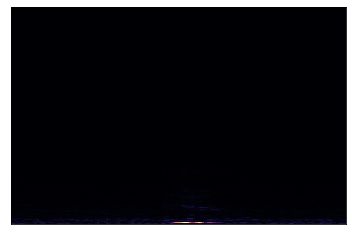

In [39]:
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

first_sample = list(audio_vectors.values())[0]
sgram = librosa.stft(first_sample)
librosa.display.specshow(sgram)

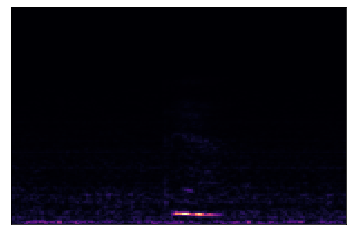

In [32]:
# use the mel-scale instead of raw frequency
sgram_mag, _ = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)
librosa.display.specshow(mel_scale_sgram)

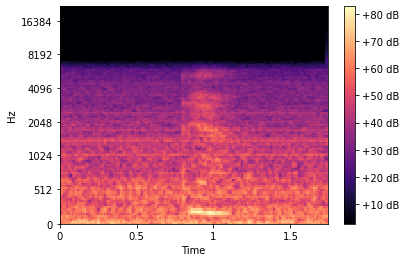

In [38]:
# use the decibel scale to get the final Mel Spectrogram
mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
librosa.display.specshow(mel_sgram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')